In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import time
import joblib

# Start time
start_time = time.time()

# Load the data
documents_path = os.path.expanduser('~\\Documents')
os.chdir(documents_path)
df = pd.read_excel('final_data.xlsx')

# Define complaints and categories
complaints = df["Complaint"]
categories = df["Category Level 1"]

# Reduce data
subset_ratio = 1
subset_size = int(len(complaints) * subset_ratio)
complaints = complaints[:subset_size]
categories = categories[:subset_size]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(complaints, categories, test_size=0.2, random_state=123)

import nltk
import re
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Download necessary NLTK data
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("tagsets")
nltk.download("stopwords")

# Define stopwords and stemmer
stops = stopwords.words("indonesian")
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Define preprocessing functions
def extract_words(text):
    words = [word.lower() for word in re.findall("[^\d\W]+", text)]
    return words

def filter_words(words, stops, stemmer):
    filtered_words = [word for word in words if word not in stops]
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    return stemmed_words

def tokenise(text, stops, stemmer):
    return filter_words(extract_words(text), stops, stemmer)

# Prepare tokeniser for TF-IDF Vectorizer
from functools import partial
from sklearn.feature_extraction.text import TfidfVectorizer

tokeniser_partial = partial(tokenise, stemmer=stemmer, stops=stops)
tfidf_vectorizer = TfidfVectorizer(analyzer=tokeniser_partial)

end_time = time.time()
runtime = end_time - start_time
print(f"runtime: {runtime:.2f} seconds")

runtime: 11.78 seconds


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aagm1n23\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aagm1n23\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\aagm1n23\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aagm1n23\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define SVM kernels to test
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
best_kernel = None
best_score = 0
results = {}

# Start time
start_time = time.time()

# Perform cross-validation for each kernel
for kernel in kernels:
    print(f"Evaluating kernel: {kernel}")
    pipeline_svm = Pipeline([
        ('vectorizer', tfidf_vectorizer),
        ('classifier', SVC(kernel=kernel))
    ])
    
    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    cv_scores = cross_val_score(pipeline_svm, X_train, y_train, cv=skf, n_jobs=-1)
    
    mean_cv_score = cv_scores.mean()
    results[kernel] = mean_cv_score
    
    print(f"Mean CV Accuracy for kernel '{kernel}': {mean_cv_score:.4f}")
    
    # Select the best kernel
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_kernel = kernel

print(f"Best kernel: {best_kernel} with CV accuracy: {best_score:.4f}")
# Train the final model on the entire training set using the best kernel
pipeline_svm = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('classifier', SVC(kernel=best_kernel))
])
pipeline_svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = pipeline_svm.predict(X_test)

# Get classification report for detailed evaluation
report = classification_report(y_test, y_pred_svm, labels=categories.unique())
print(report)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy on Test Set: {accuracy_svm }")

# Confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm, labels=categories.unique())
conf_matrix_df_svm = pd.DataFrame(conf_matrix_svm, index=categories.unique(), columns=categories.unique())

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_df_svm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM')
plt.show()

# End time
end_time = time.time()
runtime = end_time - start_time
print(f"runtime: {runtime:.2f} seconds")

Evaluating kernel: linear


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time

# Define SVM kernels to test
alphas = [0.01, 0.1, 1.0, 10.0]
best_alpha = None
best_score = 0
results = {}

# Start time
start_time = time.time()

# Perform cross-validation for each kernel
for alpha in alphas:
    print(f"Evaluating alpha: {alpha}")
    pipeline_nb = Pipeline([
        ('vectorizer', tfidf_vectorizer),
        ('classifier', MultinomialNB(alpha=alpha))  # Pass alpha as a keyword argument
    ])

    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    cv_scores = cross_val_score(pipeline_nb, X_train, y_train, cv=skf, n_jobs=-1)

    mean_cv_score = cv_scores.mean()
    results[kernel] = mean_cv_score

    print(f"Mean CV Accuracy for alpha '{alpha}': {mean_cv_score:.4f}")

    # Select the best kernel
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_alpha = alpha

print(f"Best alpha: {best_alpha} with CV accuracy: {best_score:.4f}")

# Train the final model on the entire training set using the best kernel
pipeline_nb = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('classifier', MultinomialNB(alpha=best_alpha))
])
pipeline_nb.fit(X_train, y_train)

# Predict on the test set
y_pred_nb = pipeline_nb.predict(X_test)

# Get classification report for detailed evaluation
report = classification_report(y_test, y_pred_nb, labels=categories.unique())
print(report)

# Evaluate accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb * 100:.2f}%")

# Confusion matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb, labels=categories.unique())
conf_matrix_df_nb = pd.DataFrame(conf_matrix_nb, index=categories.unique(), columns=categories.unique())

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_df_nb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

# End time
end_time = time.time()
runtime = end_time - start_time
print(f"Runtime: {runtime:.2f} seconds")

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Define the pipeline with NMF
pipeline_mlp = Pipeline([
    ('vectorizer', TfidfVectorizer()),  
    ('classifier', MLPClassifier(hidden_layer_sizes=[512, 256],  # Three hidden layers with decreasing size
                                 activation='relu',
                                 solver='adam',
                                 alpha=0.0001,
                                 batch_size='auto',
                                 max_iter=60,
                                 tol=0.0001,
                                 verbose=2,
                                 n_iter_no_change=5,
                                 validation_fraction=0.2))
])

# Start time
start_time = time.time()

# Train the pipeline
pipeline_mlp.fit(X_train, y_train)

# Predict on the test set
y_pred_mlp = pipeline_mlp.predict(X_test)

# Get classification report for detailed evaluation
report = classification_report(y_test, y_pred_mlp, labels=categories.unique())
print(report)

# Evaluate accuracy
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Accuracy: {accuracy_mlp * 100:.2f}%")

# Confusion matrix
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp, labels=categories.unique())
conf_matrix_df_mlp = pd.DataFrame(conf_matrix_mlp, index=categories.unique(), columns=categories.unique())

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_df_mlp, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLP')
plt.show()

# End time
end_time = time.time()
runtime = end_time - start_time
print(f"Runtime: {runtime:.2f} seconds")

Iteration 1, loss = 1.28000208
Iteration 2, loss = 0.46225314
Iteration 3, loss = 0.16586681
Iteration 4, loss = 0.08532216
Iteration 5, loss = 0.06263273
Iteration 6, loss = 0.05094599
Iteration 7, loss = 0.04346381
Iteration 8, loss = 0.03949620
Iteration 9, loss = 0.03410683
Iteration 10, loss = 0.03277398
Iteration 11, loss = 0.03052219
Iteration 12, loss = 0.02761539
Iteration 13, loss = 0.02671970
Iteration 14, loss = 0.02553074
Iteration 15, loss = 0.02336598
Iteration 16, loss = 0.02418229
Iteration 17, loss = 0.02554621
Iteration 18, loss = 0.03029108
Iteration 19, loss = 0.04064881
Iteration 20, loss = 0.05280503
Iteration 21, loss = 0.03821619
Training loss did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


NameError: name 'classification_report' is not defined

                                                      precision    recall  f1-score   support

                   Public Works and Spatial Planning       0.78      0.80      0.79      2046
Village Development, Rural Areas, and Transmigration       0.45      0.41      0.43       214
                               Economics and Finance       0.54      0.56      0.55      1070
                                              Health       0.60      0.66      0.63       893
                           Population Administration       0.81      0.74      0.77       839
                                    Politics and Law       0.42      0.44      0.43       562
                                          Employment       0.70      0.80      0.75      1705
               Public Order and Community Protection       0.62      0.63      0.62      1131
            Information and communication technology       0.76      0.74      0.75      1308
                          Environmental and forestry       

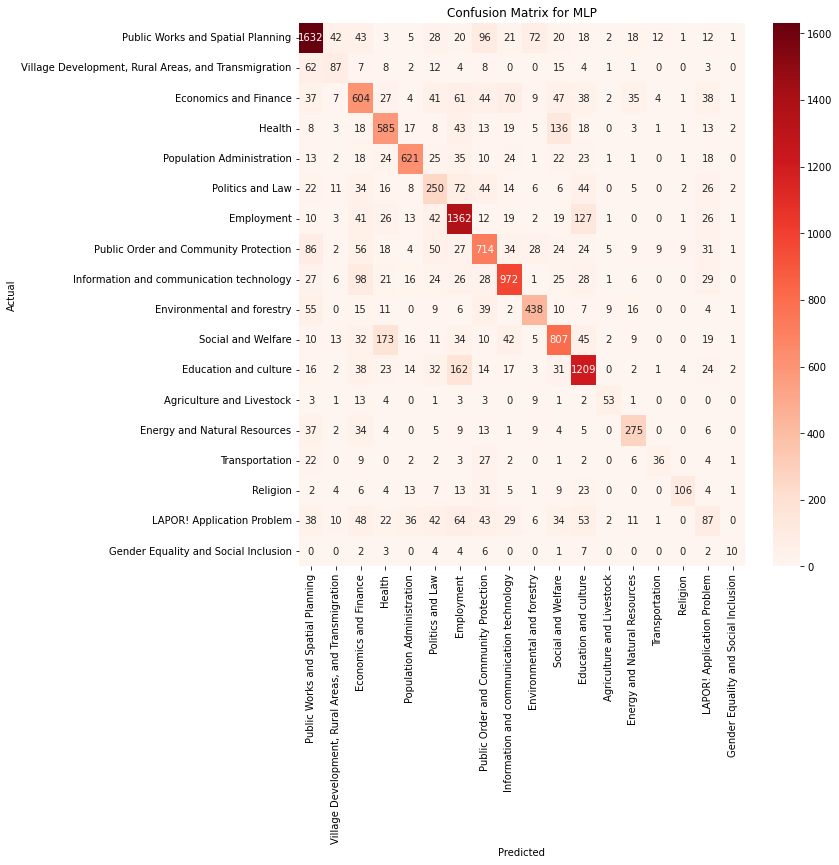

Runtime: 25756.41 seconds


In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Get classification report for detailed evaluation
report = classification_report(y_test, y_pred_mlp, labels=categories.unique())
print(report)

# Evaluate accuracy
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Accuracy: {accuracy_mlp * 100:.2f}%")

# Confusion matrix
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp, labels=categories.unique())
conf_matrix_df_mlp = pd.DataFrame(conf_matrix_mlp, index=categories.unique(), columns=categories.unique())

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_df_mlp, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLP')
plt.show()

# End time
end_time = time.time()
runtime = end_time - start_time
print(f"Runtime: {runtime:.2f} seconds")